In [1]:
# !pip3 install ninja

In [1]:
import argparse
import math
import os

import torch
from torch import optim
from torch.nn import functional as F
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from model import Generator
import numpy as np
from torchvision import utils
import lpips
import cv2
import time
from IPython.display import display, clear_output

In [2]:
import math

import torch
from torch import nn
from encoders import psp_encoders
from model import Generator

In [3]:
from psp import pSp

In [4]:
def ShowImageAtRunTime(inputTensor):
    x = torch.permute(inputTensor, (1, 2, 0)).cpu().detach().numpy()
    x = (x -  np.min(x))/(np.max(x) - np.min(x))
    plt.imshow(x)
    plt.show()

def ReturnImage(inputTensor):
    x = torch.permute(inputTensor, (1, 2, 0)).cpu().detach().numpy()
    x = (x -  np.min(x))/(np.max(x) - np.min(x))
    return x

def ShowImageUsingOpenCV(inputTensor, waitTime = 0.01):
    '''
    Input: Tensor of shape (3, W, H)
    This Allows Images to be displayed as the loop runs
    Note: OpenCV allow BGR and not RGB.
    '''
    x = torch.permute(inputTensor[0], (1, 2, 0)).cpu().detach().numpy()

    x = x[...,::-1]
    x = (x -  np.min(x))/(np.max(x) - np.min(x))
    cv2.imshow("Predicted Image",x)
    time.sleep(waitTime)
    
def SaveImageFromTensor(sample, path):
    utils.save_image(
        sample,
        path,
        nrow=1,
        normalize=True,
        range=(-1, 1),
    )
    return

In [6]:
if __name__ == "__main__":

    print("Made w Love")
    device = "cuda"


    parser = argparse.ArgumentParser(description="Generate samples from the generator")

    parser.add_argument(
        "--size", type=int, default=256, help="output image size of the generator"
    )
    parser.add_argument(
        "--sample",
        type=int,
        default=1,
        help="number of samples to be generated for each image",
    )
    parser.add_argument(
        "--pics", type=int, default=20, help="number of images to be generated"
    )
    parser.add_argument("--truncation", type=float, default=1, help="truncation ratio")
    parser.add_argument(
        "--truncation_mean",
        type=int,
        default=4096,
        help="number of vectors to calculate mean for the truncation",
    )
    parser.add_argument(
        "--ckpt",
        type=str,
        default="stylegan2-ffhq-config-f.pt",
        help="path to the model checkpoint",
    )
    parser.add_argument(
        "--channel_multiplier",
        type=int,
        default=2,
        help="channel multiplier of the generator. config-f = 2, else = 1",
    )

    args = parser.parse_args([])

    args.latent = 512
    args.n_mlp = 8



    #Load Model
    g_ema = Generator(
        args.size, args.latent, args.n_mlp, channel_multiplier=args.channel_multiplier
    ).to(device)
    checkpoint = torch.load(args.ckpt)

    g_ema.load_state_dict(checkpoint["g_ema"], strict=False)

    if args.truncation < 1:
        with torch.no_grad():
            mean_latent = g_ema.mean_latent(args.truncation_mean)
    else:
        mean_latent = None

Made w Love


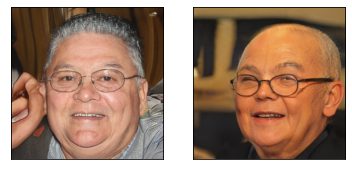

In [6]:
#Generate Target or Load from Image
with torch.no_grad():
    g_ema.eval()
    sample_z = torch.from_numpy(np.random.RandomState(44).randn(1, 512)).to(device)
    print(sample_z[0][0])
    sample_z = sample_z.float()
    GroundTruth, _ = g_ema([sample_z], truncation_latent=None)


print('ground truth image')
plt.figure(figsize=(15, 10))
ax = plt.gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ShowImageAtRunTime(GroundTruth[0])


# ShowImageAtRunTime(GroundTruth)

#This is the Z that we are trying to learn
learnedZ = torch.randn(args.sample, args.latent, device=device)

#Require Gradients
learnedZ.requires_grad = True

#Define optimizer
optimizer = optim.Adam([learnedZ], lr=0.1)

#Define your loss
criterion = lpips.PerceptualLoss(
    model="net-lin", net="vgg", use_gpu=device.startswith("cuda")
)

fig=plt.figure()
print('start training')
for i in range(10):
    y, _ = g_ema([learnedZ], truncation_latent=None)
    loss = criterion(y, GroundTruth).sum()


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


#         print(f'i = {i} -- loss = {loss.item()}')



    #This controls the learning rate
    if i % 1000 == 0 and i != 0:
        optimizer.param_groups[0]["lr"] *= 0.5



    #If you dont want to view images as the loop runs, comment this block
    if i % 1 == 0 and i != 0:
        clear_output(wait=True)
        plt.subplot(121)
        plt.imshow(ReturnImage(y[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.subplot(122)
        plt.imshow(ReturnImage(GroundTruth[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.show()

    #Save the images!
    if i % 50 == 0 and i != 0:
        Save_path = f'./learningZSpace/{i}.png'
        SaveImageFromTensor(y, Save_path)
        print("Saved Successfuly at ", Save_path)

In [9]:
# with torch.no_grad():
#     g_ema.eval()
#     sample_z = torch.from_numpy(np.random.RandomState(44).randn(32, 512)).to(device)
#     print(sample_z[0][0])
#     sample_z = sample_z.float()
#     GroundTruth, _ = g_ema([sample_z], truncation_latent=None)
# GroundTruth.shape

tensor(-0.7506, device='cuda:0', dtype=torch.float64)


torch.Size([32, 3, 256, 256])

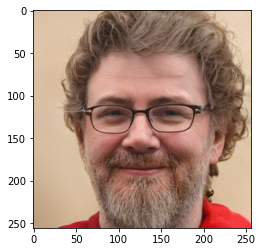

In [10]:
# ShowImageAtRunTime(GroundTruth[2])

In [7]:
net = pSp().to(device)

In [8]:
with torch.no_grad():
    sample_z = torch.from_numpy(np.random.randn(10, 512)).to(device)
    sample_z = sample_z.float()
    img, _ = g_ema([sample_z], truncation_latent=None)
    img_hat, latent = net.forward(img, return_latents=True)

In [9]:
img_hat[0].shape

torch.Size([3, 256, 256])

In [10]:
img.shape

torch.Size([10, 3, 256, 256])

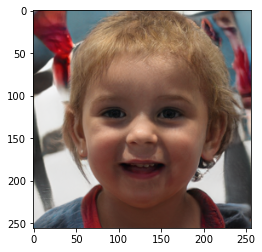

In [18]:
ShowImageAtRunTime(img[3])

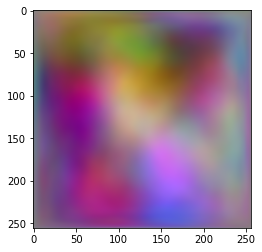

In [19]:
ShowImageAtRunTime(img_hat[3])

In [21]:
# Initializations
lr = 0.0001
device = 'cuda:0'

net = pSp().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

g_ema.eval()
net.train()

criterion = lpips.PerceptualLoss(
    model="net-lin", net="vgg", use_gpu=device.startswith("cuda")
)

for i in range(1000):
    sample_z = torch.from_numpy(np.random.randn(32, 512)).to(device)
    sample_z = sample_z.float()
    img, _ = g_ema([sample_z], truncation_latent=None)
    img_hat, _ = net.forward(img, return_latents=True)
    
    optimizer.zero_grad()
    loss = criterion(img_hat, img).sum()
    loss.backward()
    optimizer.step()

Setting up Perceptual loss...
Loading model from: /home/hamoudkh/research/inversion/stylegan2-pytorch/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


In [22]:
with torch.no_grad():
    sample_z = torch.from_numpy(np.random.randn(10, 512)).to(device)
    sample_z = sample_z.float()
    img, _ = g_ema([sample_z], truncation=0.5, truncation_latent=True)
    img_hat, latent = net.forward(img, return_latents=True)

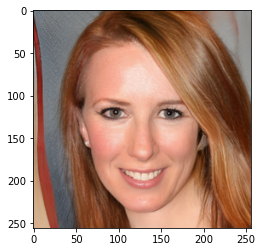

In [23]:
ShowImageAtRunTime(img[3])

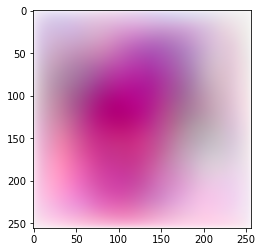

In [27]:
ShowImageAtRunTime(img_hat[3])

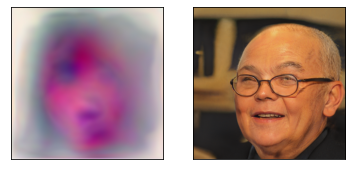

i= 480


In [7]:
# Initializations
with torch.no_grad():
    g_ema.eval()
    sample_z = torch.from_numpy(np.random.RandomState(44).randn(1, 512)).to(device)
    print(sample_z[0][0])
    sample_z = sample_z.float()
    GroundTruth, _ = g_ema([sample_z], truncation_latent=None)


lr = 0.0001
device = 'cuda:0'

net = pSp().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

g_ema.eval()
net.train()

criterion = lpips.PerceptualLoss(
    model="net-lin", net="vgg", use_gpu=device.startswith("cuda")
)

print('ground truth image')
plt.figure(figsize=(15, 10))
ax = plt.gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ShowImageAtRunTime(GroundTruth[0])


for i in range(500):
    sample_z = torch.from_numpy(np.random.randn(10, 512)).to(device)
    sample_z = sample_z.float()
    img, _ = g_ema([sample_z], truncation_latent=None)
    img_hat, _ = net.forward(img, return_latents=True)
    
    optimizer.zero_grad()
    loss = criterion(img_hat, img).sum()
    loss.backward()
    optimizer.step()
    
    
    if i % 20 == 0 and i != 0:
        with torch.no_grad():
            img_hat, _ = net.forward(GroundTruth, return_latents=True)
        clear_output(wait=True)
        plt.subplot(121)
        plt.imshow(ReturnImage(img_hat[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.subplot(122)
        plt.imshow(ReturnImage(GroundTruth[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.show()
        
        print('i=',i)

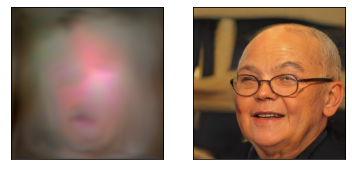

iter: 1000/500, Loss : 6.090: 100%|████████| 1000/1000 [19:13<00:00,  1.15s/it]

iteration = 1000
loss = 6.0899224281311035


In [12]:
# Initializations
with torch.no_grad():
    g_ema.eval()
    sample_z = torch.from_numpy(np.random.RandomState(44).randn(1, 512)).to(device)
    print(sample_z[0][0])
    sample_z = sample_z.float()
    GroundTruth, _ = g_ema([sample_z], truncation_latent=None)


lr = 0.0001
device = 'cuda:0'

net = pSp(encoder_type='BackboneEncoderUsingLastLayerIntoWPlus').to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

g_ema.eval()
net.train()

criterion = lpips.PerceptualLoss(
    model="net-lin", net="vgg", use_gpu=device.startswith("cuda")
)

print('ground truth image')
plt.figure(figsize=(15, 10))
ax = plt.gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ShowImageAtRunTime(GroundTruth[0])

pbar = tqdm(range(1000))
for i in pbar:
    sample_z = torch.from_numpy(np.random.randn(10, 512)).to(device)
    sample_z = sample_z.float()
    img, _ = g_ema([sample_z], truncation_latent=None)
    img_hat, _ = net.forward(img, return_latents=True)
    
    optimizer.zero_grad()
    loss = criterion(img_hat, img).sum()
    loss.backward()
    optimizer.step()
    
    pbar.set_description(f"iter: {i+1}/{500}, Loss : {loss.item():.3f}")
    
    
    if (i+1) % 20 == 0 and i != 0:
        with torch.no_grad():
            img_hat, _ = net.forward(GroundTruth, return_latents=True)
        clear_output(wait=True)
        plt.subplot(121)
        plt.imshow(ReturnImage(img_hat[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.subplot(122)
        plt.imshow(ReturnImage(GroundTruth[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.show()
        
        print('iteration =',i+1)
        print('loss =',loss.item())

In [ ]:
# Initializations
with torch.no_grad():
    g_ema.eval()
    sample_z = torch.from_numpy(np.random.RandomState(44).randn(1, 512)).to(device)
    print(sample_z[0][0])
    sample_z = sample_z.float()
    GroundTruth, _ = g_ema([sample_z], truncation_latent=None)


lr = 0.0001
device = 'cuda:0'

losses = []

net = pSp(encoder_type='GradualStyleEncoder').to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

g_ema.eval()
net.train()

criterion = lpips.PerceptualLoss(
    model="net-lin", net="vgg", use_gpu=device.startswith("cuda")
)

print('ground truth image')
plt.figure(figsize=(15, 10))
ax = plt.gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ShowImageAtRunTime(GroundTruth[0])

iterations = 2000

pbar = tqdm(range(iterations))
for i in pbar:
    sample_z = torch.from_numpy(np.random.randn(10, 512)).to(device)
    sample_z = sample_z.float()
    img, _ = g_ema([sample_z], truncation_latent=None)
    img_hat, _ = net.forward(img, return_latents=True)
    
    optimizer.zero_grad()
    loss = criterion(img_hat, img).sum()
    loss.backward()
    optimizer.step()
    
    pbar.set_description(f"iter: {i+1}/{iterations}, Loss : {loss.item():.3f}")
    losses.append(loss.item())
    
    
    if (i+1) % 50 == 0 or i == 0:
        with torch.no_grad():
            img_hat, _ = net.forward(GroundTruth, return_latents=True)
        clear_output(wait=True)
        plt.subplot(121)
        plt.imshow(ReturnImage(img_hat[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.subplot(122)
        plt.imshow(ReturnImage(GroundTruth[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.show()
        
        print('iteration =',i+1)
        print('loss =',loss.item())

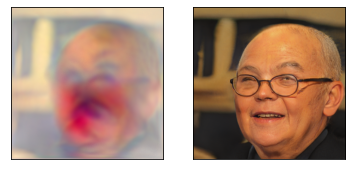

iter: 500/500, Loss : 0.336: 100%|████████████████████████████████████████████████████████| 500/500 [01:53<00:00,  4.41it/s]

iteration = 500
loss = 0.3364112675189972


In [8]:
# Initializations
with torch.no_grad():
    g_ema.eval()
    sample_z = torch.from_numpy(np.random.RandomState(44).randn(1, 512)).to(device)
    print(sample_z[0][0])
    sample_z = sample_z.float()
    GroundTruth, _ = g_ema([sample_z], truncation_latent=None)


lr = 0.0001
device = 'cuda:0'

losses = []

net = pSp(encoder_type='GradualStyleEncoder').to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

g_ema.eval()
net.train()

criterion = lpips.PerceptualLoss(
    model="net-lin", net="vgg", use_gpu=device.startswith("cuda")
)

print('ground truth image')
plt.figure(figsize=(15, 10))
ax = plt.gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ShowImageAtRunTime(GroundTruth[0])

iterations = 500

pbar = tqdm(range(iterations))
for i in pbar:
    img_hat, _ = net.forward(GroundTruth, return_latents=True)
    
    optimizer.zero_grad()
    loss = criterion(img_hat, GroundTruth).sum()
    loss.backward()
    optimizer.step()
    
    pbar.set_description(f"iter: {i+1}/{iterations}, Loss : {loss.item():.3f}")
    losses.append(loss.item())
    
    
    if (i+1) % 20 == 0 or i == 0:
        with torch.no_grad():
            img_hat, _ = net.forward(GroundTruth, return_latents=True)
        clear_output(wait=True)
        plt.subplot(121)
        plt.imshow(ReturnImage(img_hat[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.subplot(122)
        plt.imshow(ReturnImage(GroundTruth[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.show()
        
        print('iteration =',i+1)
        print('loss =',loss.item())

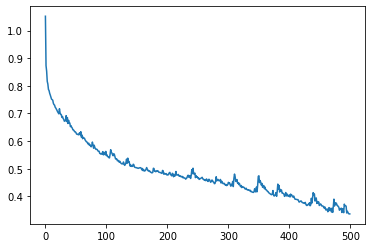

In [9]:
plt.plot(losses);

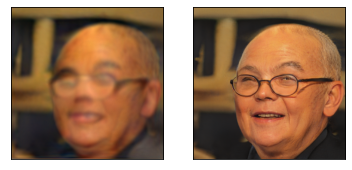

iter: 1000/1000, Loss : 0.184: 100%|████████████████████████████████████████████████████| 1000/1000 [03:43<00:00,  4.47it/s]

iteration = 1000
loss = 0.18420304358005524


In [11]:
# Initializations
with torch.no_grad():
    g_ema.eval()
    sample_z = torch.from_numpy(np.random.RandomState(44).randn(1, 512)).to(device)
    print(sample_z[0][0])
    sample_z = sample_z.float()
    GroundTruth, _ = g_ema([sample_z], truncation_latent=None)


lr = 0.0001
device = 'cuda:0'

losses = []

net = pSp(encoder_type='GradualStyleEncoder').to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

g_ema.eval()
net.train()

criterion = lpips.PerceptualLoss(
    model="net-lin", net="vgg", use_gpu=device.startswith("cuda")
)

print('ground truth image')
plt.figure(figsize=(15, 10))
ax = plt.gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ShowImageAtRunTime(GroundTruth[0])

iterations = 1000

pbar = tqdm(range(iterations))
for i in pbar:
    img_hat, _ = net.forward(GroundTruth, return_latents=True)
    
    optimizer.zero_grad()
    loss = criterion(img_hat, GroundTruth).sum()
    loss.backward()
    optimizer.step()
    
    pbar.set_description(f"iter: {i+1}/{iterations}, Loss : {loss.item():.3f}")
    losses.append(loss.item())
    
    
    if (i+1) % 20 == 0 or i == 0:
        with torch.no_grad():
            img_hat, _ = net.forward(GroundTruth, return_latents=True)
        clear_output(wait=True)
        plt.subplot(121)
        plt.imshow(ReturnImage(img_hat[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.subplot(122)
        plt.imshow(ReturnImage(GroundTruth[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.show()
        
        print('iteration =',i+1)
        print('loss =',loss.item())

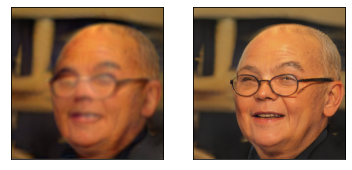

iter: 1500/1500, Loss : 0.147: 100%|██████████████████████████████████████████████████████| 500/500 [01:52<00:00,  4.43it/s]

iteration = 1500
loss = 0.14727073907852173


In [12]:
pbar = tqdm(range(iterations, iterations+500))
for i in pbar:
    img_hat, _ = net.forward(GroundTruth, return_latents=True)
    
    optimizer.zero_grad()
    loss = criterion(img_hat, GroundTruth).sum()
    loss.backward()
    optimizer.step()
    
    pbar.set_description(f"iter: {i+1}/{iterations+500}, Loss : {loss.item():.3f}")
    losses.append(loss.item())
    
    
    if (i+1) % 20 == 0 or i == 0:
        with torch.no_grad():
            img_hat, _ = net.forward(GroundTruth, return_latents=True)
        clear_output(wait=True)
        plt.subplot(121)
        plt.imshow(ReturnImage(img_hat[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.subplot(122)
        plt.imshow(ReturnImage(GroundTruth[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.show()
        
        print('iteration =',i+1)
        print('loss =',loss.item())

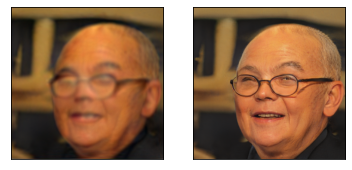

iter: 2000/2000, Loss : 0.128: 100%|██████████████████████████████████████████████████████| 500/500 [01:51<00:00,  4.50it/s]

iteration = 2000
loss = 0.1283545345067978


In [13]:
pbar = tqdm(range(iterations+500, iterations+1000))
for i in pbar:
    img_hat, _ = net.forward(GroundTruth, return_latents=True)
    
    optimizer.zero_grad()
    loss = criterion(img_hat, GroundTruth).sum()
    loss.backward()
    optimizer.step()
    
    pbar.set_description(f"iter: {i+1}/{iterations+1000}, Loss : {loss.item():.3f}")
    losses.append(loss.item())
    
    
    if (i+1) % 20 == 0 or i == 0:
        with torch.no_grad():
            img_hat, _ = net.forward(GroundTruth, return_latents=True)
        clear_output(wait=True)
        plt.subplot(121)
        plt.imshow(ReturnImage(img_hat[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.subplot(122)
        plt.imshow(ReturnImage(GroundTruth[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.show()
        
        print('iteration =',i+1)
        print('loss =',loss.item())

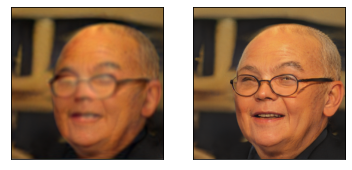

iter: 2500/2500, Loss : 0.116: 100%|██████████████████████████████████████████████████████| 500/500 [01:50<00:00,  4.51it/s]

iteration = 2500
loss = 0.11575601994991302


In [14]:
lr = 0.00001
device = 'cuda:0'

losses = []

optimizer = torch.optim.Adam(net.parameters(), lr=lr)



pbar = tqdm(range(iterations+1000, iterations+1500))
for i in pbar:
    img_hat, _ = net.forward(GroundTruth, return_latents=True)
    
    optimizer.zero_grad()
    loss = criterion(img_hat, GroundTruth).sum()
    loss.backward()
    optimizer.step()
    
    pbar.set_description(f"iter: {i+1}/{iterations+1500}, Loss : {loss.item():.3f}")
    losses.append(loss.item())
    
    
    if (i+1) % 20 == 0 or i == 0:
        with torch.no_grad():
            img_hat, _ = net.forward(GroundTruth, return_latents=True)
        clear_output(wait=True)
        plt.subplot(121)
        plt.imshow(ReturnImage(img_hat[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.subplot(122)
        plt.imshow(ReturnImage(GroundTruth[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.show()
        
        print('iteration =',i+1)
        print('loss =',loss.item())

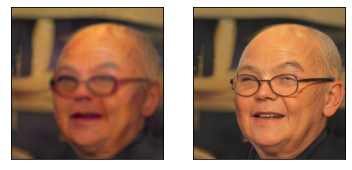

iter: 2500/2500, Loss : 0.156: 100%|████████████████████████████████████████████████████| 2500/2500 [09:24<00:00,  4.43it/s]

iteration = 2500
loss = 0.15626715123653412


In [15]:
# Initializations
with torch.no_grad():
    g_ema.eval()
    sample_z = torch.from_numpy(np.random.RandomState(44).randn(1, 512)).to(device)
    print(sample_z[0][0])
    sample_z = sample_z.float()
    GroundTruth, _ = g_ema([sample_z], truncation_latent=None)


lr = 0.0001
device = 'cuda:0'

losses = []

net = pSp(encoder_type='BackboneEncoderUsingLastLayerIntoWPlus').to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

g_ema.eval()
net.train()

criterion = lpips.PerceptualLoss(
    model="net-lin", net="vgg", use_gpu=device.startswith("cuda")
)

print('ground truth image')
plt.figure(figsize=(15, 10))
ax = plt.gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ShowImageAtRunTime(GroundTruth[0])

iterations = 2500

pbar = tqdm(range(iterations))
for i in pbar:
    img_hat, _ = net.forward(GroundTruth, return_latents=True)
    
    optimizer.zero_grad()
    loss = criterion(img_hat, GroundTruth).sum()
    loss.backward()
    optimizer.step()
    
    pbar.set_description(f"iter: {i+1}/{iterations}, Loss : {loss.item():.3f}")
    losses.append(loss.item())
    
    
    if (i+1) % 20 == 0 or i == 0:
        with torch.no_grad():
            img_hat, _ = net.forward(GroundTruth, return_latents=True)
        clear_output(wait=True)
        plt.subplot(121)
        plt.imshow(ReturnImage(img_hat[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.subplot(122)
        plt.imshow(ReturnImage(GroundTruth[0]))
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        plt.show()
        
        print('iteration =',i+1)
        print('loss =',loss.item())

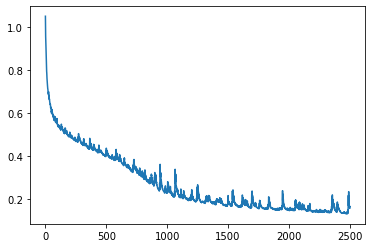

In [16]:
plt.plot(losses);